# Generative Adversial Network for MNIST

In [1]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from collections import deque

Populating the interactive namespace from numpy and matplotlib


## Model

In [2]:
z_dim = 128
class DiscriminatorModel(nn.Sequential):
    def __init__(self):
        nn.Sequential.__init__(self,
            # convolution 1
            nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # convolution 2
            nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # convolution 2
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # convolution 2
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # dense
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 1),
            nn.Sigmoid()
        )
class GeneratorModel(nn.Sequential):
    def __init__(self):
        nn.Sequential.__init__(self,
            # tranpose convolution 1 - input shape (z-dim, 1, 1)
            nn.ConvTranspose2d(z_dim, 32, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # tranpose convolution 1 - input shape (32, 7, 7)
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # tranpose convolution 2 - input shape (64, 14, 14)
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # tranpose convolution 3 - input shape (128, 28, 28)
            nn.ConvTranspose2d(128, 256, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # final tranpose convolution - input shape (256, 28, 28)
            nn.ConvTranspose2d(256, 1, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Sigmoid()
            # output shape (1, 28, 28)
        )
# custom weight initialization
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# use device if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using Device:", device)
# create models
discriminator = DiscriminatorModel().to(device)
generator = GeneratorModel().to(device)
# weight initialization
discriminator.apply(init_weights)
generator.apply(init_weights)
# create optimizers
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Using Device: cuda:0


## Training

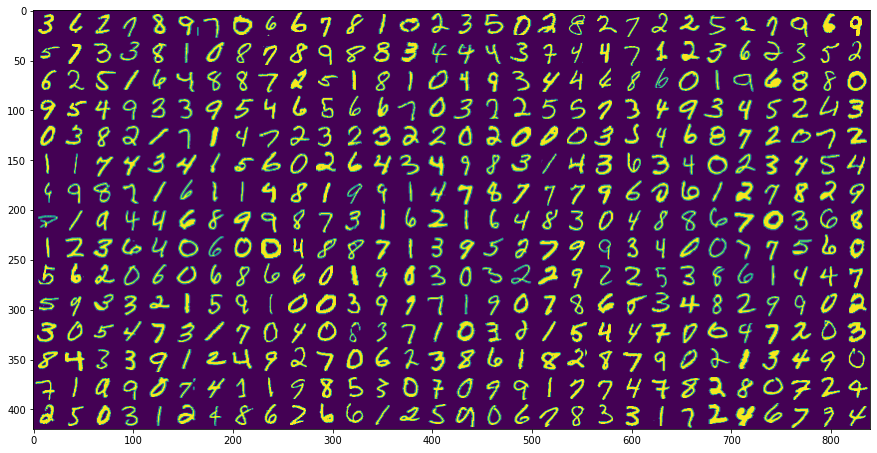

In [4]:
# load mnist data
mnist_train = MNIST('./data/', train=True, download=True, transform=ToTensor())
dataloader = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=256)
# show a few examples
n, m = 15, 30
x = mnist_train.data[torch.randint(0, len(mnist_train), (n * m,)).long()]
x = x.numpy().reshape(n, m, 28, 28)
x = x.transpose(0, 2, 1, 3).reshape(n * 28, m * 28)
figsize(n, m)
figure()
imshow(x)
show()

Train:   0%|          | 0/4700 [00:00<?, ?it/s]

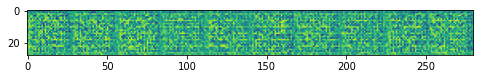

Train:  11%|█         | 500/4700 [02:36<21:39,  3.23it/s, gloss=1.6, dloss=0.824]

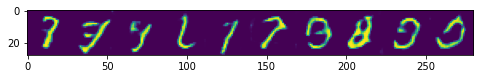

Train:  21%|██▏       | 1000/4700 [05:12<19:05,  3.23it/s, gloss=1.58, dloss=0.905]

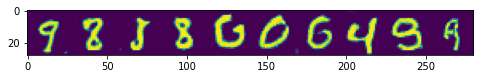

Train:  32%|███▏      | 1500/4700 [07:48<16:38,  3.20it/s, gloss=1.58, dloss=0.948]

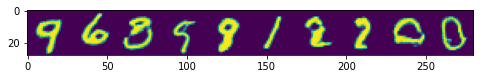

Train:  43%|████▎     | 2000/4700 [10:25<13:58,  3.22it/s, gloss=1.59, dloss=0.941]

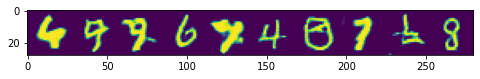

Train:  53%|█████▎    | 2500/4700 [13:01<11:32,  3.18it/s, gloss=1.49, dloss=0.975]

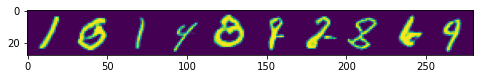

Train:  64%|██████▍   | 3000/4700 [15:38<09:02,  3.14it/s, gloss=1.52, dloss=0.995]

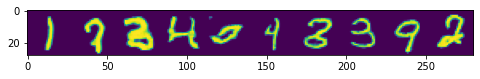

Train:  74%|███████▍  | 3500/4700 [18:16<06:22,  3.14it/s, gloss=1.44, dloss=1.04]

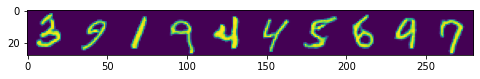

Train:  85%|████████▌ | 4000/4700 [20:55<03:35,  3.25it/s, gloss=1.37, dloss=1.05]

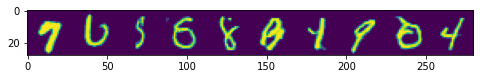

Train:  96%|█████████▌| 4500/4700 [23:33<01:02,  3.19it/s, gloss=1.43, dloss=1.02]

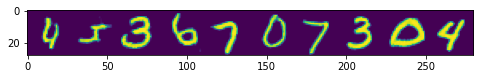

Train: 100%|██████████| 4700/4700 [24:36<00:00,  3.18it/s, gloss=1.39, dloss=1.05]


In [5]:
# training the auto-encoder
epochs, v_interval = 20, 500
# losses
last_d_losses, last_g_losses = deque(maxlen=100), deque(maxlen=100)
mean_d_losses, mean_g_losses = [], []
mean = lambda l: sum(l) / len(l)
with tqdm(total=len(dataloader) * epochs) as pbar:
    pbar.set_description("Train", refresh=True)
    # train
    discriminator.train()
    generator.train()
    for e in range(epochs):
        for i, (real_x, _) in enumerate(dataloader):
            # prepare inputs
            real_x = real_x.to(device)
            # note that it is important to use the same z/fake_x for training the discriminator and the generator
            # this way, by training the discriminator first, the generator can immediatly react on the change in the discriminator 
            # experiments show that the generator doesn't learn anything valuable with a different z/fake_x
            z = torch.randn(real_x.size(0), z_dim, 1, 1, device=device)
            fake_x = generator(z)

            # train discriminator
            real_y = discriminator(real_x)
            fake_y = discriminator(fake_x.detach())     # detach!
            # train discriminator to seperate fake inputs from the real ones
            dloss_r = F.binary_cross_entropy(real_y, torch.ones_like(real_y))
            dloss_f = F.binary_cross_entropy(fake_y, torch.zeros_like(fake_y))
            dloss = dloss_r + dloss_f
            # update parameters
            discriminator_optim.zero_grad()
            dloss.backward()
            discriminator_optim.step()
            # update losses
            last_d_losses.append(dloss.item())
            mean_d_losses.append(mean(last_d_losses))

            # train generator
            # apply discriminator on fake input and train to fool discriminator in futur by
            # considering the loss of the fake inputs being classified as real
            fake_y = discriminator(fake_x)
            gloss = F.binary_cross_entropy(fake_y, torch.ones_like(fake_y))
            # then updating only the generator weights
            generator_optim.zero_grad()
            gloss.backward()
            generator_optim.step()
            # update losses
            last_g_losses.append(gloss.item())
            mean_g_losses.append(mean(last_g_losses))

            # visualize fake images
            if (e * len(dataloader) + i) % v_interval == 0:
                # generate image from fake-x
                with torch.no_grad():
                    img = fake_x[:10, 0, ...].transpose(1, 0).reshape(28, 10 * 28)
                    img = img.cpu().numpy()
                figsize(8, 1)
                figure()
                imshow(img)
                show()

            # progress
            pbar.set_postfix({'gloss': mean_g_losses[-1], 'dloss': mean_d_losses[-1]})
            pbar.update(1)

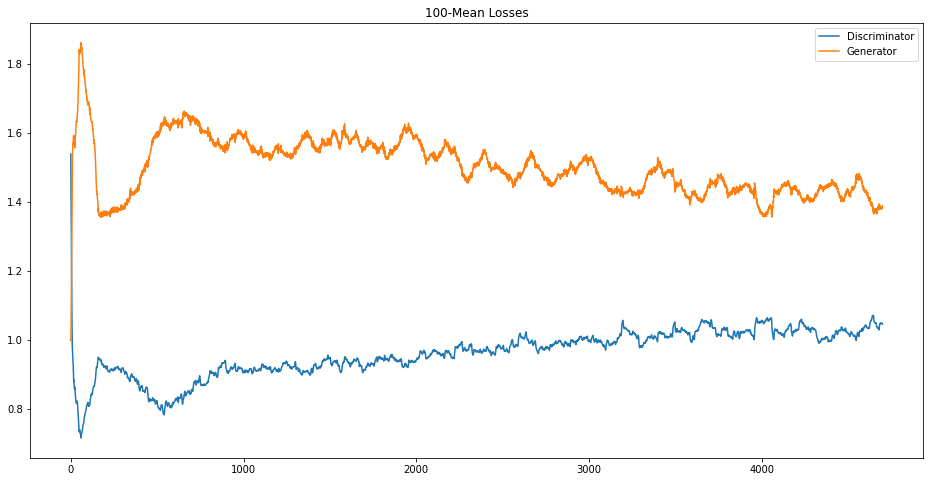

In [6]:
# plot losses
figsize(16, 8)
figure()
plot(mean_d_losses)
plot(mean_g_losses)
legend(['Discriminator', 'Generator'])
title("100-Mean Losses")
show()

## Generating

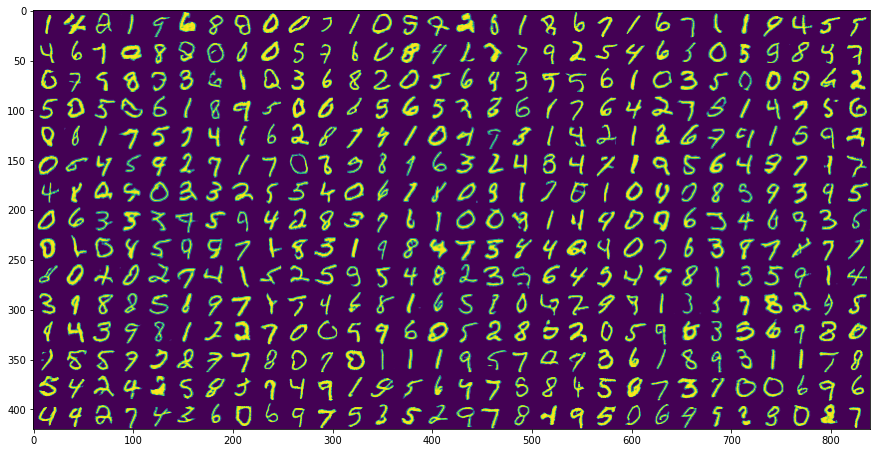

In [7]:
n, m = 15, 30
# gerenate from random
generator.eval()
with torch.no_grad():
    x = generator(torch.randn(n*m, z_dim, 1, 1, device=device))
    x = x.cpu().numpy()
# transform for visualization
x = x.reshape(n, m, 28, 28)
x = x.transpose(0, 2, 1, 3)
x = x.reshape(n * 28, m * 28)
# visualize
figsize(n, m)
figure()
imshow(x)
show()